# 🧹 Image Data Cleaning Guide
### Human Emotion Dataset — `C:/Nemeno/3rd year/2nd sem/IS2/activities/act_3/Data`

This notebook walks you through cleaning your emotion image dataset step by step:

1. **Audit the dataset** — count files per class, list formats
2. **Fix the folder name typo** — `Suprise` → `Surprise`
3. **Remove corrupted images** — files that can't be opened
4. **Remove too-small images** — images with very low resolution
5. **Detect duplicate images** — identical files (by hash)
6. **Check class balance** — visualize how many images per class
7. **Summary report** — what was removed and what remains


---
## Step 0 — Install required libraries

In [2]:
# Run this cell once if you don't have these libraries
!pip install Pillow matplotlib pandas tqdm imagehash

   ---------------------------------------- 0.0/4.2 MB ? eta -:--:--
   ------------ --------------------------- 1.3/4.2 MB 5.6 MB/s eta 0:00:01
   ------------------------------------- -- 3.9/4.2 MB 9.0 MB/s eta 0:00:01
   ---------------------------------------- 4.2/4.2 MB 8.7 MB/s  0:00:00

   ---------------------------------------- 0/2 [PyWavelets]
   ---------------------------------------- 2/2 [imagehash]




[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


---
## Step 1 — Setup & Imports

In [ ]:
import os
import hashlib
import shutil
from pathlib import Path
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# --- Configuration ---
DATA_DIR = Path(r'C:/Nemeno/3rd year/2nd sem/IS2/activities/act_3/Data')
VALID_EXTENSIONS = {'.png', '.jpg', '.jpeg', '.bmp', '.gif', '.webp'}
MIN_SIZE_PX = 48   # Minimum width AND height in pixels

print(f"Data directory: {DATA_DIR}")
print(f"Exists: {DATA_DIR.exists()}")


Data directory: C:\Nemeno\3rd year\2nd sem\IS2\Data
Exists: True


---
## Step 2 — Audit: Count files per class

In [6]:
classes = [d.name for d in DATA_DIR.iterdir() if d.is_dir()]
print(f"Found classes: {classes}\n")

audit = []
for cls in classes:
    cls_dir = DATA_DIR / cls
    files = list(cls_dir.iterdir())
    by_ext = {}
    for f in files:
        ext = f.suffix.lower()
        by_ext[ext] = by_ext.get(ext, 0) + 1
    audit.append({'Class': cls, 'Total Files': len(files), **by_ext})

audit_df = pd.DataFrame(audit).fillna(0)
int_cols = [c for c in audit_df.columns if c != 'Class']
audit_df[int_cols] = audit_df[int_cols].astype(int)
print(audit_df.to_string(index=False))


Found classes: ['Angry', 'Fear', 'Happy', 'Sad', 'Suprise']

  Class  Total Files  .png  .jpg  .jpeg
  Angry        10148  9906   242      0
   Fear         9732  9714    18      0
  Happy        18438 17983   363     92
    Sad        12553 12157   395      1
Suprise         8227  8004   223      0


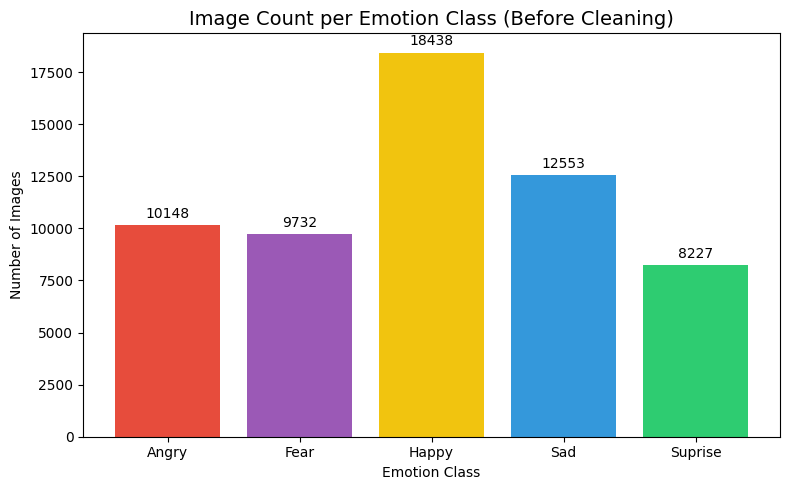


Total images across all classes: 59098


In [7]:
# Visualize class counts
totals = {row['Class']: row['Total Files'] for row in audit}

fig, ax = plt.subplots(figsize=(8, 5))
bars = ax.bar(totals.keys(), totals.values(), color=['#e74c3c','#9b59b6','#f1c40f','#3498db','#2ecc71'])
ax.bar_label(bars, padding=3)
ax.set_title('Image Count per Emotion Class (Before Cleaning)', fontsize=14)
ax.set_ylabel('Number of Images')
ax.set_xlabel('Emotion Class')
plt.tight_layout()
plt.show()

print(f"\nTotal images across all classes: {sum(totals.values())}")

---
## Step 3 — Fix Folder Name Typo: `Suprise` → `Surprise`

> ⚠️ **Run this only ONCE!** After renaming, the old folder name no longer exists.

In [9]:
old_name = DATA_DIR / 'Suprise'
new_name = DATA_DIR / 'Surprise'

if old_name.exists() and not new_name.exists():
    old_name.rename(new_name)
    print(f"✅ Renamed: '{old_name.name}'  →  '{new_name.name}'")
elif new_name.exists():
    print(f"ℹ️  '{new_name.name}' already exists — no action needed.")
else:
    print(f"⚠️  '{old_name.name}' not found. Check the folder name manually.")


ℹ️  'Surprise' already exists — no action needed.


---
## Step 4 — Remove Non-Image Files

Check for files with unexpected extensions inside the class folders.

In [10]:
# Re-detect classes after rename
classes = [d.name for d in DATA_DIR.iterdir() if d.is_dir()]

non_image_files = []

for cls in classes:
    cls_dir = DATA_DIR / cls
    for f in cls_dir.iterdir():
        if f.suffix.lower() not in VALID_EXTENSIONS:
            non_image_files.append({'Class': cls, 'File': f.name, 'Extension': f.suffix})

if non_image_files:
    print(f"Found {len(non_image_files)} non-image files:")
    print(pd.DataFrame(non_image_files).to_string(index=False))
else:
    print("✅ No non-image files found.")

✅ No non-image files found.


In [ ]:
# OPTIONAL: Delete non-image files
# Uncomment to actually delete:

# for item in non_image_files:
#     file_path = DATA_DIR / item['Class'] / item['File']
#     file_path.unlink()
#     print(f"Deleted: {file_path}")

print("(Deletion is commented out for safety. Uncomment lines above to delete.)")

---
## Step 5 — Remove Corrupted Images

A corrupted image is one that **cannot be opened** by Pillow.  
This can happen if a file was partially downloaded or is just an empty/broken file.

In [11]:
corrupted_files = []

for cls in classes:
    cls_dir = DATA_DIR / cls
    files = [f for f in cls_dir.iterdir() if f.suffix.lower() in VALID_EXTENSIONS]
    
    for f in tqdm(files, desc=f'Checking [{cls}]', leave=False):
        try:
            with Image.open(f) as img:
                img.verify()   # checks file integrity without loading all pixel data
        except Exception as e:
            corrupted_files.append({'Class': cls, 'File': f.name, 'Error': str(e)})

print(f"\nTotal corrupted images found: {len(corrupted_files)}")
if corrupted_files:
    print(pd.DataFrame(corrupted_files).to_string(index=False))


Total corrupted images found: 0


In [ ]:
# OPTIONAL: Move corrupted files to a 'quarantine' folder instead of deleting
QUARANTINE_DIR = DATA_DIR.parent / 'quarantine'

# for item in corrupted_files:
#     src = DATA_DIR / item['Class'] / item['File']
#     dst_dir = QUARANTINE_DIR / item['Class']
#     dst_dir.mkdir(parents=True, exist_ok=True)
#     shutil.move(str(src), str(dst_dir / item['File']))
#     print(f"Moved: {item['File']} -> quarantine/{item['Class']}/")

print("(Move is commented out for safety. Uncomment to move corrupted files.)")

---
## Step 6 — Remove Too-Small Images

Images smaller than **32x32 pixels** are usually too blurry or uninformative for training a model.

In [12]:
small_files = []

for cls in classes:
    cls_dir = DATA_DIR / cls
    files = [f for f in cls_dir.iterdir() if f.suffix.lower() in VALID_EXTENSIONS]
    
    for f in tqdm(files, desc=f'Size check [{cls}]', leave=False):
        try:
            with Image.open(f) as img:
                w, h = img.size
                if w < MIN_SIZE_PX or h < MIN_SIZE_PX:
                    small_files.append({'Class': cls, 'File': f.name, 'Width': w, 'Height': h})
        except:
            pass   # already flagged as corrupted

print(f"\nImages smaller than {MIN_SIZE_PX}x{MIN_SIZE_PX}px: {len(small_files)}")
if small_files:
    print(pd.DataFrame(small_files).sort_values('Width').head(20).to_string(index=False))


Images smaller than 48x48px: 0


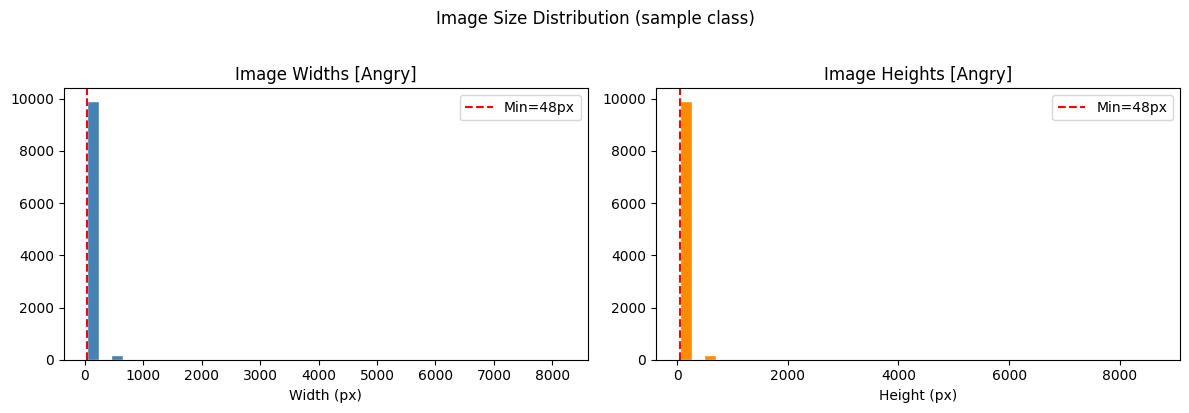

In [13]:
# Visualize image size distribution
widths, heights = [], []

sample_cls = classes[0]  # Just sample one class for speed
for f in (DATA_DIR / sample_cls).iterdir():
    if f.suffix.lower() in VALID_EXTENSIONS:
        try:
            with Image.open(f) as img:
                w, h = img.size
                widths.append(w)
                heights.append(h)
        except:
            pass

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(widths, bins=40, color='steelblue', edgecolor='white')
axes[0].set_title(f'Image Widths [{sample_cls}]')
axes[0].set_xlabel('Width (px)')
axes[0].axvline(MIN_SIZE_PX, color='red', linestyle='--', label=f'Min={MIN_SIZE_PX}px')
axes[0].legend()

axes[1].hist(heights, bins=40, color='darkorange', edgecolor='white')
axes[1].set_title(f'Image Heights [{sample_cls}]')
axes[1].set_xlabel('Height (px)')
axes[1].axvline(MIN_SIZE_PX, color='red', linestyle='--', label=f'Min={MIN_SIZE_PX}px')
axes[1].legend()

plt.suptitle('Image Size Distribution (sample class)', y=1.02)
plt.tight_layout()
plt.show()

---
## Step 7 — Detect Duplicate Images (by MD5 Hash)

Exact duplicates are detected by computing the **MD5 hash** of each file.  
If two files have the same hash → they are byte-for-byte identical.

In [14]:
def file_hash(filepath):
    """Return MD5 hash of file content."""
    h = hashlib.md5()
    with open(filepath, 'rb') as f:
        while chunk := f.read(8192):
            h.update(chunk)
    return h.hexdigest()

hash_map = {}   # { hash -> list of file paths }

for cls in classes:
    cls_dir = DATA_DIR / cls
    files = [f for f in cls_dir.iterdir() if f.suffix.lower() in VALID_EXTENSIONS]
    
    for f in tqdm(files, desc=f'Hashing [{cls}]', leave=False):
        try:
            h = file_hash(f)
            hash_map.setdefault(h, []).append(f)
        except:
            pass

# Find groups with more than one file
duplicate_groups = {h: paths for h, paths in hash_map.items() if len(paths) > 1}

total_dupes = sum(len(v) - 1 for v in duplicate_groups.values())
print(f"\nDuplicate groups found: {len(duplicate_groups)}")
print(f"Redundant files (extra copies) to remove: {total_dupes}")

if duplicate_groups:
    for i, (h, paths) in enumerate(list(duplicate_groups.items())[:5]):
        print(f"\n  Group {i+1} (hash: {h[:10]}...):")
        for p in paths:
            print(f"    {p.parent.name}/{p.name}")


Duplicate groups found: 2585
Redundant files (extra copies) to remove: 3180

  Group 1 (hash: 6740fa2934...):
    Angry/10002.png
    Angry/233.png

  Group 2 (hash: 1cad15f66a...):
    Angry/10016.png
    Angry/29263.png

  Group 3 (hash: c885faf6fa...):
    Angry/10047185.png
    Angry/96211906.png

  Group 4 (hash: 219d1c07f4...):
    Angry/10063.png
    Angry/21310.png
    Angry/25288.png
    Angry/29788.png
    Angry/34620.png

  Group 5 (hash: f6c8547f04...):
    Angry/10079.png
    Angry/1564.png
    Angry/20539.png


In [28]:
# OPTIONAL: Delete duplicate files (keep the first occurrence, delete the rest)

# deleted_dupes = []
# for h, paths in duplicate_groups.items():
#     for dup in paths[1:]:   # keep paths[0], delete the rest
#         dup.unlink()
#         deleted_dupes.append(str(dup))

# print(f"Deleted {len(deleted_dupes)} duplicate files.")

# print("(Deletion is commented out for safety. Uncomment to remove duplicates.)")

# humana ni 

---
## Step 8 — Preview Sample Images

Visually spot-check a few images from each class to make sure they look correct.

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'C:\\Nemeno\\3rd year\\2nd sem\\IS2\\Data\\Angry'

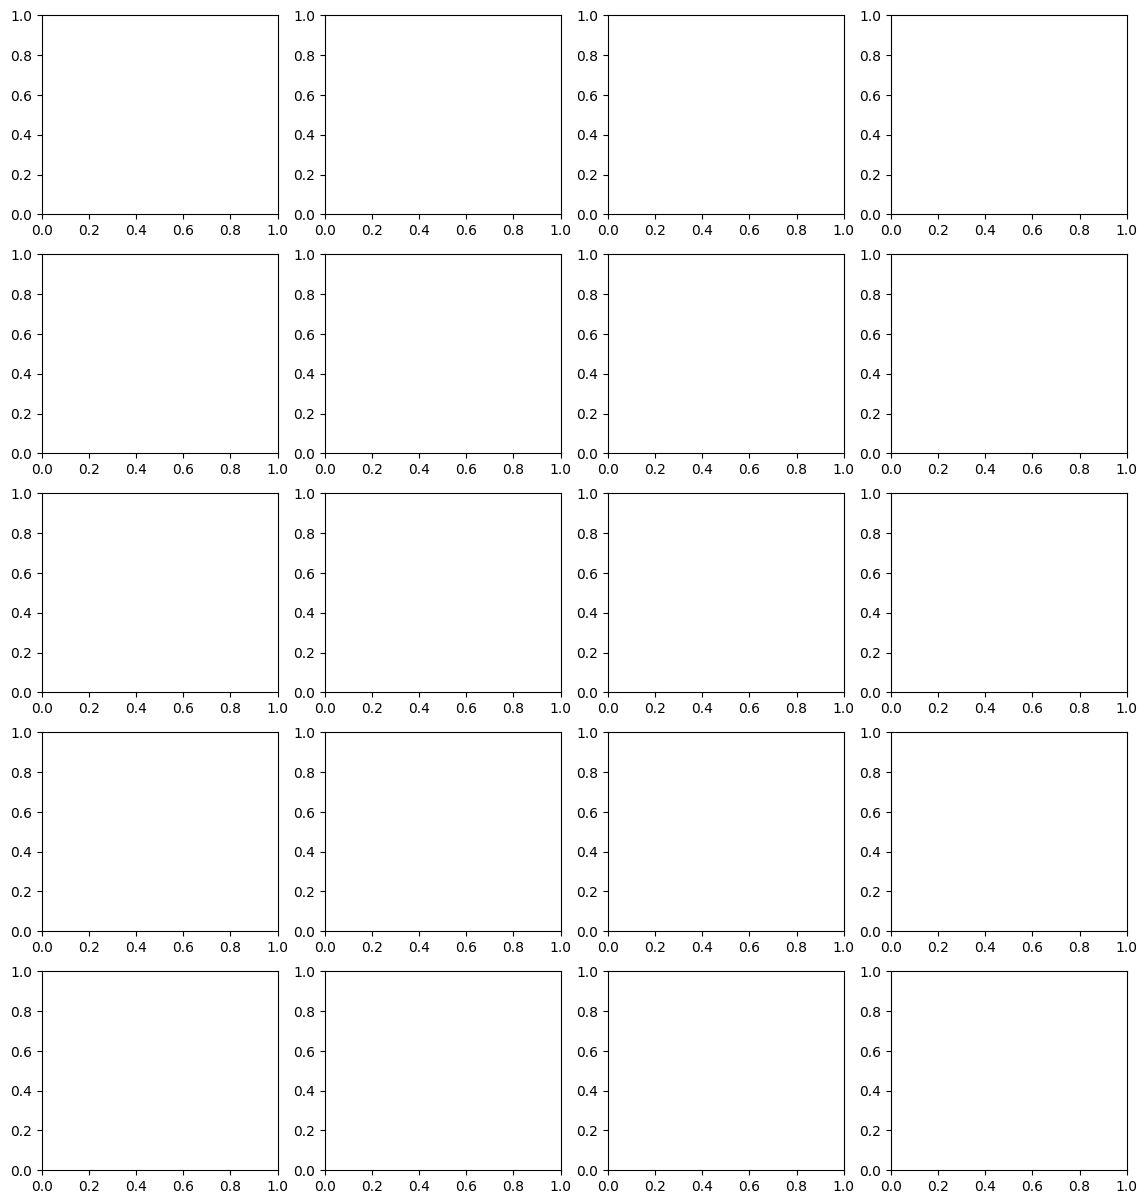

In [29]:
import random

n_preview = 4   # images per class
fig, axes = plt.subplots(len(classes), n_preview, figsize=(14, 3 * len(classes)))

for row_idx, cls in enumerate(sorted(classes)):
    cls_dir = DATA_DIR / cls
    all_images = [f for f in cls_dir.iterdir() if f.suffix.lower() in VALID_EXTENSIONS]
    sample = random.sample(all_images, min(n_preview, len(all_images)))
    
    for col_idx in range(n_preview):
        ax = axes[row_idx][col_idx]
        if col_idx < len(sample):
            try:
                img = Image.open(sample[col_idx]).convert('RGB')
                ax.imshow(img)
                ax.set_title(sample[col_idx].name[:20], fontsize=7)
            except Exception as e:
                ax.set_title('ERROR', color='red', fontsize=8)
        ax.axis('off')
    
    axes[row_idx][0].set_ylabel(cls, fontsize=12, rotation=90, labelpad=5)

plt.suptitle('Sample Images per Emotion Class', fontsize=14, y=1.01)
plt.tight_layout()
plt.show()

---
## Step 9 — Class Balance Report

Class          Images  % of total
Angry            9722       17.4%
Fear             9193       16.4%
Happy           18057       32.3%
Sad             12225       21.9%
Surprise         6721       12.0%
TOTAL           55918      100.0%


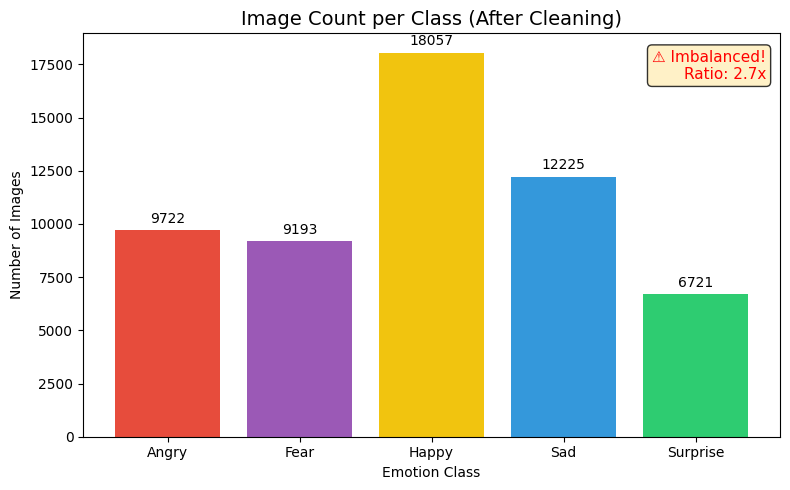

In [23]:
after_counts = {}
for cls in sorted(classes):
    cls_dir = DATA_DIR / cls
    count = len([f for f in cls_dir.iterdir() if f.suffix.lower() in VALID_EXTENSIONS])
    after_counts[cls] = count

total = sum(after_counts.values())
print("=" * 40)
print(f"{'Class':<12} {'Images':>8}  {'% of total':>10}")
print("=" * 40)
for cls, cnt in after_counts.items():
    pct = 100 * cnt / total
    print(f"{cls:<12} {cnt:>8}  {pct:>9.1f}%")
print("=" * 40)
print(f"{'TOTAL':<12} {total:>8}  {'100.0%':>10}")

# Visualize
fig, ax = plt.subplots(figsize=(8, 5))
colors = ['#e74c3c','#9b59b6','#f1c40f','#3498db','#2ecc71']
bars = ax.bar(after_counts.keys(), after_counts.values(), color=colors[:len(after_counts)])
ax.bar_label(bars, padding=3)
ax.set_title('Image Count per Class (After Cleaning)', fontsize=14)
ax.set_ylabel('Number of Images')
ax.set_xlabel('Emotion Class')

# Add imbalance warning if max/min ratio > 2
max_c = max(after_counts.values())
min_c = min(after_counts.values())
if max_c / min_c > 2:
    ax.text(0.98, 0.96, f'⚠️ Imbalanced!\nRatio: {max_c/min_c:.1f}x',
            transform=ax.transAxes, ha='right', va='top',
            fontsize=11, color='red',
            bbox=dict(boxstyle='round', facecolor='#ffeeba', alpha=0.8))

plt.tight_layout()
plt.show()

---
## Step 10 — Final Summary

---
## Step 11 — Resize & Export to `Data_clean/`

Every image is resized to **48×48 pixels** and converted to **RGB** (3 channels), then saved to a new folder `Data_clean/` next to your original `Data/` folder.

> ✅ Your original images are **never modified** — the cleaned copies go to `Data_clean/`.

In [26]:
TARGET_SIZE = (48, 48)
CLEAN_DIR = DATA_DIR.parent / 'Data_clean'

skipped = 0
exported = 0

for cls in sorted(classes):
    src_dir = DATA_DIR / cls
    dst_dir = CLEAN_DIR / cls
    dst_dir.mkdir(parents=True, exist_ok=True)

    images = [f for f in src_dir.iterdir() if f.suffix.lower() in VALID_EXTENSIONS]

    for f in tqdm(images, desc=f'Resizing [{cls}]'):
        try:
            with Image.open(f) as img:
                img = img.convert('RGB')                   # ensure 3-channel colour
                img = img.resize(TARGET_SIZE, Image.LANCZOS)  # high-quality downscale
                out_path = dst_dir / (f.stem + '.jpg')     # save everything as .jpg
                img.save(out_path, 'JPEG', quality=95)
                exported += 1
        except Exception as e:
            skipped += 1

print(f"\n✅ Done!")
print(f"   Exported : {exported} images  →  {CLEAN_DIR}")
print(f"   Skipped  : {skipped} (corrupted / unreadable)")
print(f"\nNew folder structure:")
for cls in sorted(classes):
    count = len(list((CLEAN_DIR / cls).glob('*.jpg')))
    print(f"   Data_clean/{cls}:  {count} images")

Resizing [Surprise]: 100%|██████████| 6721/6721 [00:14<00:00, 464.42it/s] 



✅ Done!
   Exported : 55918 images  →  C:\Nemeno\3rd year\2nd sem\IS2\Data_clean
   Skipped  : 0 (corrupted / unreadable)

New folder structure:
   Data_clean/Angry:  9722 images
   Data_clean/Fear:  9193 images
   Data_clean/Happy:  18057 images
   Data_clean/Sad:  12225 images
   Data_clean/Surprise:  6721 images


In [27]:
print("\n" + "="*50)
print("          CLEANING SUMMARY")
print("="*50)
print(f"  Classes found         : {len(classes)}")
print(f"  Classes               : {', '.join(sorted(classes))}")
print(f"  Total images (clean)  : {total}")
print(f"  Corrupted images      : {len(corrupted_files)}")
print(f"  Too-small images      : {len(small_files)}")
print(f"  Duplicate groups      : {len(duplicate_groups)}")
print(f"  Redundant duplicates  : {total_dupes}")
print("="*50)
print()

if corrupted_files or small_files or total_dupes > 0:
    print("⚠️  Action required:")
    if corrupted_files:
        print(f"   - Review and remove {len(corrupted_files)} corrupted files (Step 5)")
    if small_files:
        print(f"   - Consider removing {len(small_files)} images smaller than {MIN_SIZE_PX}px (Step 6)")
    if total_dupes > 0:
        print(f"   - Remove {total_dupes} exact duplicate images (Step 7)")
else:
    print("✅ Dataset looks clean!")

if max_c / min_c > 2:
    print(f"\n⚠️  Class imbalance detected (ratio {max_c/min_c:.1f}x).")
    print("   Consider augmenting under-represented classes or using weighted loss.")


          CLEANING SUMMARY
  Classes found         : 5
  Classes               : Angry, Fear, Happy, Sad, Surprise
  Total images (clean)  : 55918
  Corrupted images      : 0
  Too-small images      : 0
  Duplicate groups      : 2585
  Redundant duplicates  : 3180

⚠️  Action required:
   - Remove 3180 exact duplicate images (Step 7)

⚠️  Class imbalance detected (ratio 2.7x).
   Consider augmenting under-represented classes or using weighted loss.


---
## 📚 What's Next?

After cleaning, common next steps are:

| Step | What to do |
|------|------------|
| **Resize** | Standardize all images to e.g. 224×224 or 48×48 |
| **Normalize** | Scale pixel values to [0, 1] or use ImageNet mean/std |
| **Augment** | Flip, rotate, crop — especially for under-represented classes |
| **Split** | Divide into train / validation / test sets |
| **Label encode** | Map class names to integers: `Angry=0, Fear=1, Happy=2, Sad=3, Surprise=4` |